## Name: Shiven Tripathi
## Roll No.: 190816
## Email: shiven@iitk.ac.in

# Problem 3: RME Prediction with MDP Unknown

In [1]:
!pip install -e .

Obtaining file:///C:/Users/shive/OneDrive/Desktop/Sem%205/CS698/CS698-Deep-Reinforcement-Learning/MIDSEM/midsem
  Attempting uninstall: midsem
    Found existing installation: midsem 0.0.1
    Uninstalling midsem-0.0.1:
      Successfully uninstalled midsem-0.0.1
  Running setup.py develop for midsem


In [1]:
import gym 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
'''
This Optimal Policy was found using Value Iteration
'''
pi =[ 
    [1, 1, 1, 1],
    [3, 1, 1, 3],
    [1, 1, 1, 3],
]

print(pi)
print(np.shape(pi))
pi = np.reshape(pi, (12,))
print(pi)

[[1, 1, 1, 1], [3, 1, 1, 3], [1, 1, 1, 3]]
(3, 4)
[1 1 1 1 3 1 1 3 1 1 1 3]


In [3]:
def generateTrajectory(env, pi, maxSteps):
  '''
  env: gym env
  pi: 1d array mapping from state to actions 
    pi[state] = [action]
  maxSteps: int
  '''
  trajectory = []
  env.reset()
  for i in range(maxSteps):
    s = env.state
    # env.render()
    a = pi[s]
    s_, r, terminal, _ = env.step(a)
    trajectory.append((s,a,r,s_))
    if terminal is True:
      # env.render()
      return trajectory
  return []

In [4]:
def testGenerateTrajectory(pi=None):
  if pi is None:
    pi = np.ones((12,))
  rme = gym.make('midsem.envs:RME-v0')  
  T = generateTrajectory(env=rme, pi=pi, maxSteps=10)
  for t, (s,a,r,s_) in enumerate(T):
    print("Step:",t)
    print("State:",s,"Action:",a,"Reward:",r,"Next State:",s_)

testGenerateTrajectory(pi)

Step: 0
State: 0 Action: 1 Reward: -0.04 Next State: 1
Step: 1
State: 1 Action: 1 Reward: -0.04 Next State: 2
Step: 2
State: 2 Action: 1 Reward: 1 Next State: 3


In [5]:
def decayAlpha(initialValue, finalValue, maxSteps, decayType='exponential'):
  '''
  initialValue: float
  finalValue: float
  maxSteps: int
  decayType: string
  '''
  alphas = []
  for i in range(maxSteps):
    if decayType == 'linear':
      alpha = initialValue + i*(finalValue-initialValue)/(maxSteps-1)
    if decayType == 'exponential':
      alpha = initialValue*((finalValue/initialValue)**(i/(maxSteps-1)))
    alphas.append(alpha)
  return alphas

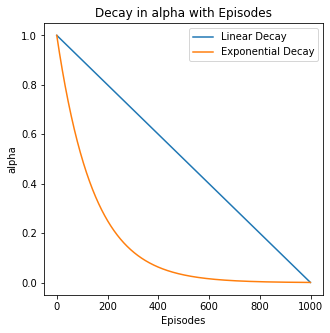

In [6]:
def testDecayAlpha(initialValue=1, finalValue=10**-3, maxSteps=10**3):
    plt.rcParams["figure.figsize"] = (5,5)
    plt.title("Decay in alpha with Episodes")  
    plt.xlabel('Episodes')
    plt.ylabel('alpha')  
    plt.plot(np.arange(maxSteps),decayAlpha(initialValue,finalValue,maxSteps,'linear'), label='Linear Decay')
    plt.plot(np.arange(maxSteps),decayAlpha(initialValue,finalValue,maxSteps,'exponential'), label='Exponential Decay')
    plt.legend()
    plt.show()

testDecayAlpha()

In [7]:
def monteCarloPrediction(env, pi, gamma, alpha_start, alpha_end, maxSteps, maxEpisodes, firstVisit, decayType='exponential'):
  '''
  env: gym env
  pi: 
  gamma: float
  alpha: float
  maxSteps: int
  maxEpisodes: int
  firstVisit: boolean
    toggle FVMC/EVMC updates
  '''
  v = np.zeros(env.observation_space.n)
  v_r = np.zeros((maxEpisodes, env.observation_space.n))
  g = np.zeros((maxEpisodes,env.observation_space.n))
  alphas = decayAlpha(alpha_start, alpha_end, maxEpisodes, decayType)

  for e in range(maxEpisodes):
    t = generateTrajectory(env, pi, maxSteps)
    visited = np.zeros(env.observation_space.n)

    for i, (s,a,r,s_) in enumerate(t):
      if visited[s] and firstVisit:
        continue

      G = 0
      for j in range(len(t)):
        G += gamma**(j-i)*t[j][2]
      g[e][s] = G
      v[s] += alphas[e]*(G-v[s])

    v_r[e] = v 
  return v_r,g

In [8]:
def testMonteCarloPrediction(pi=None):
  if pi is None:
    pi = np.ones((12,))
  rme = gym.make('midsem.envs:RME-v0')  
  print("Testing FVMC")
  vrs,_ = monteCarloPrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=5*10**3, firstVisit=True, decayType='exponential')
  print("FVMC Estimates: ",vrs[-1])
  rme.reset()
  print("Testing EVMC")
  vrs,_ = monteCarloPrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=5*10**3, firstVisit=False, decayType='exponential')
  print("EVMC Estimates: ",vrs[-1])
testMonteCarloPrediction(pi)

Testing FVMC
FVMC Estimates:  [0.8854804  0.88191744 0.88675993 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Testing EVMC
EVMC Estimates:  [0.87099653 0.87373725 0.88843873 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


In [9]:
def temporalDifferencePrediction(env, pi, gamma, alpha_start, alpha_end, maxEpisodes, decayType='exponential'):
  '''
  env: gym env
  pi: 
  gamma: float
  alpha: float
  maxEpisodes: int
  '''
  v = np.zeros(env.observation_space.n)
  v_r = np.zeros((maxEpisodes, env.observation_space.n))
  g = np.zeros((maxEpisodes,env.observation_space.n))
  alphas = decayAlpha(alpha_start, alpha_end, maxEpisodes, decayType)
  for e in range(maxEpisodes):
    env.reset()
    s = env.state
    terminal = False

    while not terminal:
      a = pi[s]
      # a = np.argmax(pi[s])
      s_, r, terminal, _ = env.step(a)
      # print(a,s,s_)
      td_target = r

      if not terminal:
        td_target += gamma*v[s_]

      g[e][s] = td_target
      td_error = td_target - v[s]
      v[s] += alphas[e]*td_error
      s = s_
    v_r[e] = v
  return v_r,g

In [10]:
def testTemporalDifferencePrediction(pi=None):
  if pi is None:
    pi = np.ones((12,))
  rme = gym.make('midsem.envs:RME-v0') 
  print("Testing TD")
  vrs,_ = temporalDifferencePrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**3, decayType='exponential')
  print("TD Estimates: ",vrs[-1])

testTemporalDifferencePrediction(pi)

Testing TD
TD Estimates:  [0.89650608 0.94007408 0.99120294 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


In [11]:
def generatePath(env, pi, s, n):
    '''
    env: gym env
    pi: policy
    s: int
    n: int
    '''
    path = []
    for i in range(n):
        a = pi[s]
        s_, r, terminal, _ = env.step(a)
        path.append((s,a,r,s_))
        s = s_
        if terminal is True:
            return path,s_,True
    return path,s_,False

In [12]:
def testGeneratePath(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0')
    rme.reset()
    path,s_,term = generatePath(rme,pi,rme.state,4)
    for step in path:
        print(step)
testGeneratePath(pi)

(0, 1, -0.04, 1)
(1, 1, -0.04, 2)
(2, 1, 1, 3)


In [13]:
def calculateReturn(path, gamma=0.999):
    '''
    path: list of tuples
    gamma: float
    '''
    G = 0
    for i in range(len(path)):
        G += (gamma**i)*path[i][2]
    return G

In [14]:
def nStepTemporalDifferencePrediction(env, n, pi, gamma, alpha_start, alpha_end, maxEpisodes, decayType='exponential'):
  '''
  env: gym env
  pi: 
  gamma: float
  alpha: float
  maxEpisodes: int
  '''
  v = np.zeros(env.observation_space.n)
  v_r = np.zeros((maxEpisodes, env.observation_space.n))
  g = np.zeros((maxEpisodes,env.observation_space.n))
  alphas = decayAlpha(alpha_start, alpha_end, maxEpisodes, decayType)
  for e in range(maxEpisodes):
    env.reset()
    s = env.state
    terminal = False
    path = []
    while not terminal and path is not None:
        path, s_, terminal = generatePath(env, pi, s, n)
        target = calculateReturn(path, gamma)
        if not terminal:
          target += (gamma**n)*v[s_]
        ntd_error = target - v[s]
        v[s] += alphas[e]*ntd_error
        if len(path) == 1 and terminal:
          path = None
    v_r[e] = v
  return v_r,g

In [15]:
def testNStepTemporalDifferencePrediction(pi=None):
  if pi is None:
    pi = np.ones((12,))
  rme = gym.make('midsem.envs:RME-v0') 
  print("Testing N Step TD")
  vrs,_ = nStepTemporalDifferencePrediction(env=rme, n=3, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**2, decayType='exponential')
  print("N Step TD Estimates: ",vrs[-1])

testNStepTemporalDifferencePrediction(pi)

Testing N Step TD
N Step TD Estimates:  [0.70132103 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


In [16]:
def TDLambdaPrediction(env, pi, gamma, alpha_start, alpha_end, Lambda, maxEpisodes, decayType='exponential'):
  '''
  env: gym env
  pi: 
  gamma: float
  alpha: float
  maxEpisodes: int
  '''
  v = np.zeros(env.observation_space.n)
  v_r = np.zeros((maxEpisodes, env.observation_space.n))
  g = np.zeros((maxEpisodes,env.observation_space.n))
  alphas = decayAlpha(alpha_start, alpha_end, maxEpisodes, decayType)
  E = np.zeros((maxEpisodes,env.observation_space.n))
  E_timed = []
  for e in range(maxEpisodes):
    env.reset()
    s = env.state
    terminal = False
    E_eps = []
    while not terminal:
      if e != 0:
        E[e] = gamma*Lambda*E[e-1]
      E_eps.append(E[e])
      a = pi[s]
      s_, r, terminal, _ = env.step(a)
      td_target = r
      if not terminal:
        td_target += gamma*v[s_]
      g[e][s] = td_target
      td_error = td_target - v[s]
      E[e][s] += 1
      v += alphas[e]*td_error*E[e]
      s = s_
    v_r[e] = v
    E_timed.append(E_eps)
  return v_r,g,E,E_timed


In [17]:
def testTDLambdaPrediction(pi=None):
  if pi is None:
    pi = np.ones((12,))
  rme = gym.make('midsem.envs:RME-v0') 
  print("Testing TD Lambda")
  vrs,_,E,_ = TDLambdaPrediction(rme, pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, Lambda=0.3, maxEpisodes=5*10**3, decayType='exponential')
  print("TD Lambda Estimates: ",vrs[-1])
  print("E: ",E[-1])

testTDLambdaPrediction()

Testing TD Lambda
TD Lambda Estimates:  [0.89618244 0.94463419 0.9911973  0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
E:  [0.         0.         1.42795945 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


Testing EVMC
EVMC Estimates: [0.87381346 0.85923532 0.86953654 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


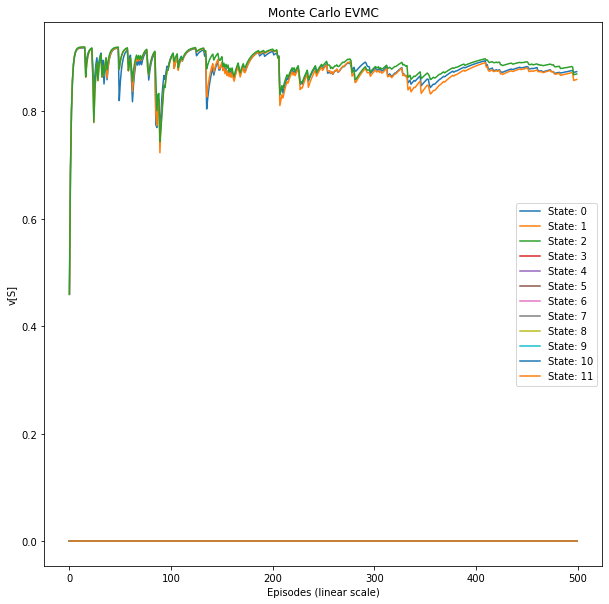

In [18]:
def MCEVMCLinear(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing EVMC")
    vrs,_ = monteCarloPrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=False, decayType='exponential')
    print("EVMC Estimates:",vrs[-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo EVMC")  
    plt.xlabel('Episodes (linear scale)')
    plt.ylabel('v[S]')
    for i in range(rme.observation_space.n):
        plt.plot(np.arange(500), vrs[:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

MCEVMCLinear(pi)

Testing FVMC
FVMC Estimates: [0.89491189 0.89349306 0.89729024 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


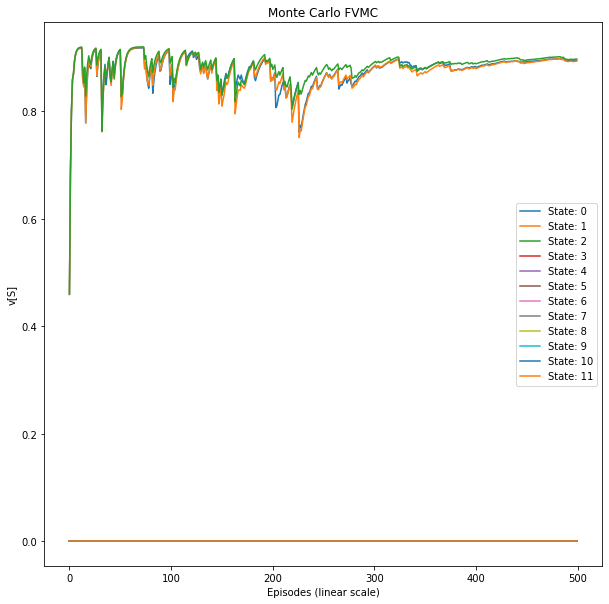

In [19]:
def MCFVMCLinear(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing FVMC")
    vrs,_ = monteCarloPrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=True, decayType='exponential')
    print("FVMC Estimates:",vrs[-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo FVMC")  
    plt.xlabel('Episodes (linear scale)')
    plt.ylabel('v[S]')
    for i in range(rme.observation_space.n):
        plt.plot(np.arange(500), vrs[:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

MCFVMCLinear(pi)

Testing TD
TD Estimates: [0.89820978 0.94094022 0.98991687 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


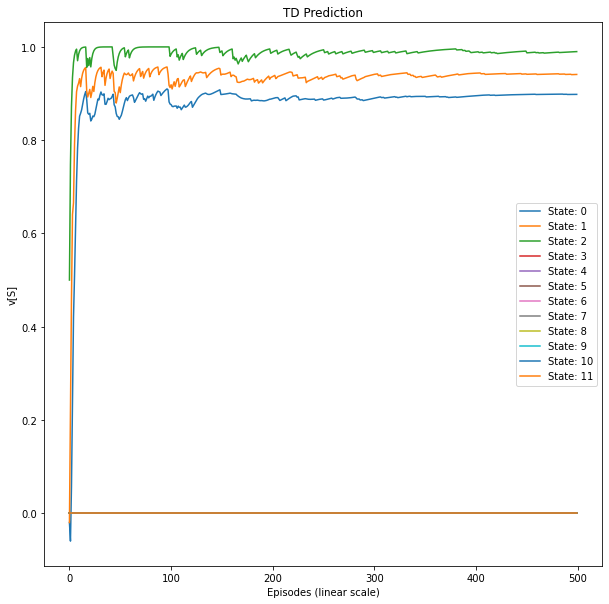

In [20]:
def TDLinear(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing TD")
    vrs,_ = temporalDifferencePrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**2, decayType='exponential')
    print("TD Estimates:",vrs[-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("TD Prediction")  
    plt.xlabel('Episodes (linear scale)')
    plt.ylabel('v[S]')
    for i in range(rme.observation_space.n):
        plt.plot(np.arange(5*10**2), vrs[:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

TDLinear(pi)

Testing TD
TD Lambda Estimates: [0.88714557 0.93490029 0.98867235 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


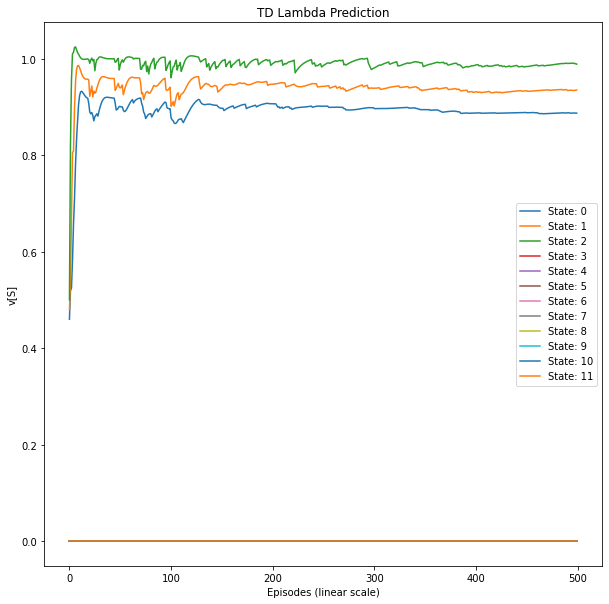

In [21]:
def TDLambdaLinear(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing TD")
    vrs,_,E,_ = TDLambdaPrediction(rme, pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, Lambda=0.3, maxEpisodes=5*10**2, decayType='exponential')
    print("TD Lambda Estimates:",vrs[-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("TD Lambda Prediction")  
    plt.xlabel('Episodes (linear scale)')
    plt.ylabel('v[S]')
    for i in range(rme.observation_space.n):
        plt.plot(np.arange(5*10**2), vrs[:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

TDLambdaLinear(pi)

Testing N Step TD
N Step TD Estimates:  [0.74449844 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


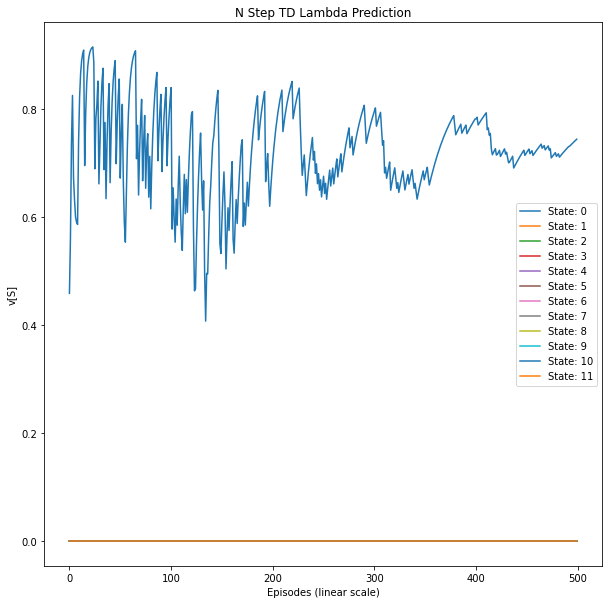

In [22]:
def NStepTDLambdaLinear(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing N Step TD")
    vrs,_ = nStepTemporalDifferencePrediction(env=rme, n=3, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**2, decayType='exponential')
    print("N Step TD Estimates: ",vrs[-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("N Step TD Lambda Prediction")  
    plt.xlabel('Episodes (linear scale)')
    plt.ylabel('v[S]')
    for i in range(rme.observation_space.n):
        plt.plot(np.arange(5*10**2), vrs[:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

NStepTDLambdaLinear(pi)

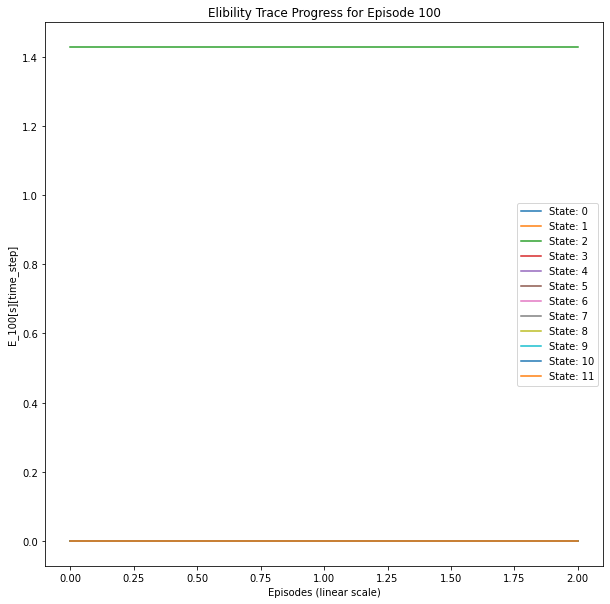

In [23]:
def eligibilityTrace(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0')  
    rme.reset()
    _,_,_,E_timed = TDLambdaPrediction(rme, pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, Lambda=0.3, maxEpisodes=5*10**2, decayType='exponential')
    plt.title("Elibility Trace Progress for Episode 100")  
    plt.xlabel('Episodes (linear scale)')
    plt.ylabel('E_100[s][time_step]')
    for i in range(12):
        plt.plot( np.arange(np.shape(E_timed[100])[0]), np.transpose(E_timed[100])[i], label=('State: '+str(i)))
    plt.legend()
    plt.show()
eligibilityTrace(pi)

Testing EVMC
EVMC Estimates: [0.87361058 0.87311335 0.8845732  0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


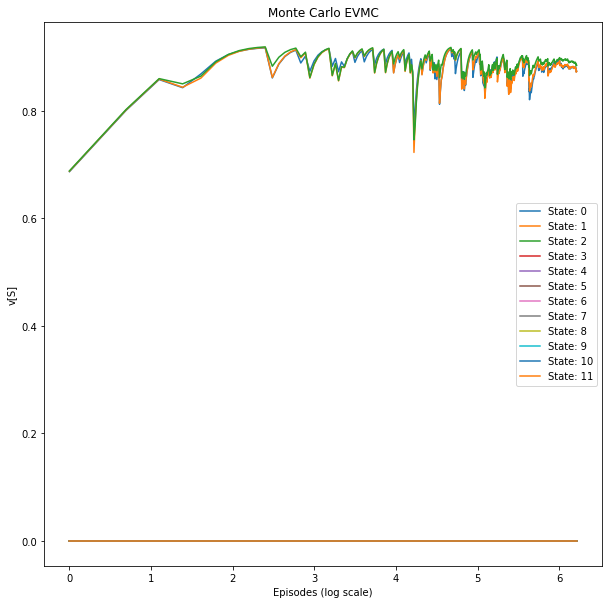

In [34]:
def MCEVMCLog(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing EVMC")
    vrs,_ = monteCarloPrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=False, decayType='exponential')
    print("EVMC Estimates:",vrs[-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo EVMC")  
    plt.xlabel('Episodes (log scale)')
    plt.ylabel('v[S]')
    for i in range(rme.observation_space.n):
        plt.plot(np.log(np.arange(1,500)), vrs[1:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

MCEVMCLog(pi)

Testing FVMC
FVMC Estimates: [0.86869678 0.87005172 0.88224334 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


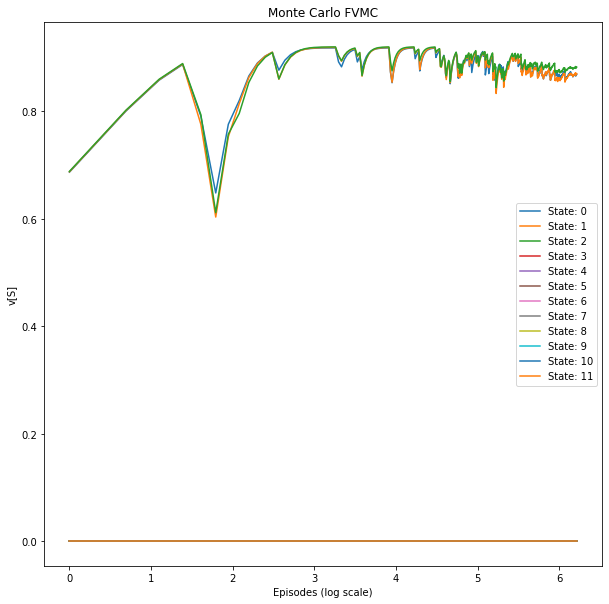

In [35]:
def MCFVMCLog(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing FVMC")
    vrs,_ = monteCarloPrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=False, decayType='exponential')
    print("FVMC Estimates:",vrs[-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo FVMC")  
    plt.xlabel('Episodes (log scale)')
    plt.ylabel('v[S]')
    for i in range(rme.observation_space.n):
        plt.plot(np.log(np.arange(1,500)), vrs[1:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

MCFVMCLog(pi)

Testing TD
TD Estimates: [0.89556358 0.93947283 0.99130909 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


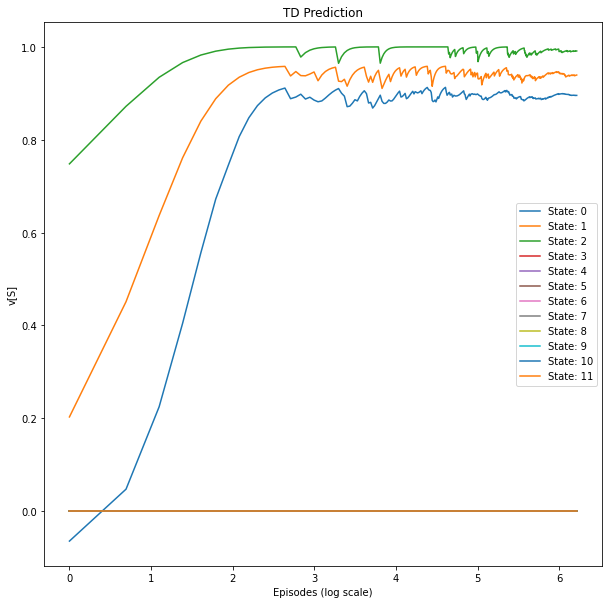

In [26]:
def TDLog(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing TD")
    vrs,_ = temporalDifferencePrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**2, decayType='exponential')
    print("TD Estimates:",vrs[-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("TD Prediction")  
    plt.xlabel('Episodes (log scale)')
    plt.ylabel('v[S]')
    for i in range(rme.observation_space.n):
        plt.plot(np.log(np.arange(1,5*10**2)), vrs[1:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

TDLog(pi)

Testing N Step TD
N Step TD Estimates:  [0.6875206 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.       ]


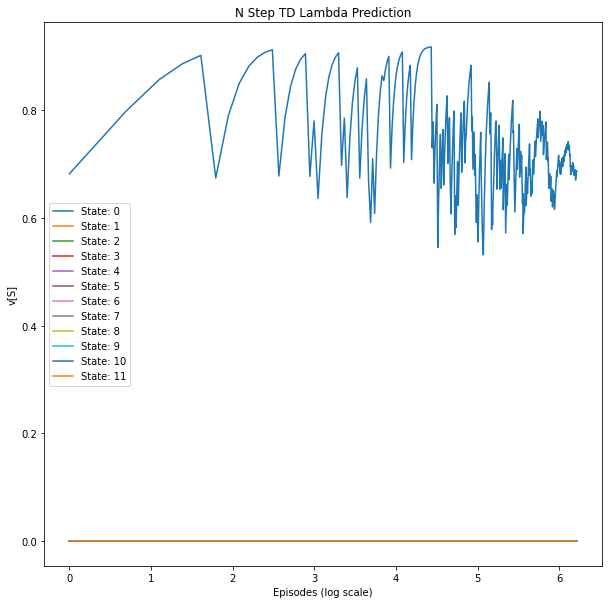

In [27]:
def NStepTDLambdaLog(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing N Step TD")
    vrs,_ = nStepTemporalDifferencePrediction(env=rme, n=3, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**2, decayType='exponential')
    print("N Step TD Estimates: ",vrs[-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("N Step TD Lambda Prediction")  
    plt.xlabel('Episodes (log scale)')
    plt.ylabel('v[S]')
    for i in range(rme.observation_space.n):
        plt.plot(np.log(np.arange(1,5*10**2)), vrs[1:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

NStepTDLambdaLog(pi)

Testing TD
TD Lambda Estimates: [0.89053559 0.93347855 0.98774756 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


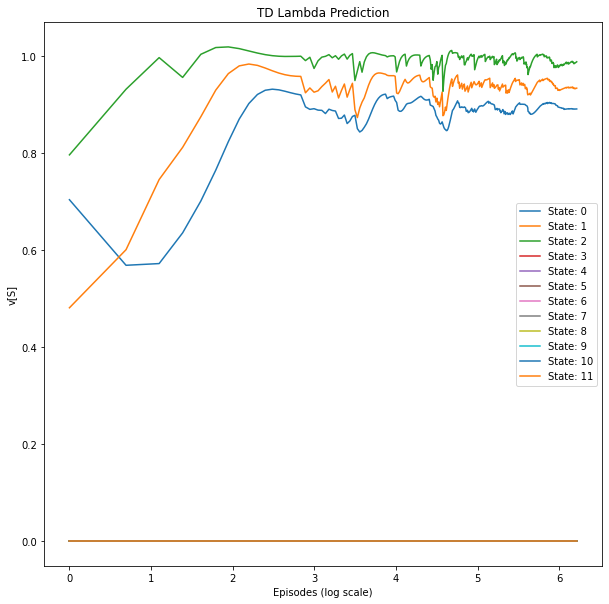

In [28]:
def TDLambdaLog(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing TD")
    vrs,_,E,_ = TDLambdaPrediction(rme, pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, Lambda=0.3, maxEpisodes=5*10**2, decayType='exponential')
    print("TD Lambda Estimates:",vrs[-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("TD Lambda Prediction")  
    plt.xlabel('Episodes (log scale)')
    plt.ylabel('v[S]')
    for i in range(rme.observation_space.n):
        plt.plot(np.log(np.arange(1,5*10**2)), vrs[1:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

TDLambdaLog(pi)

Testing FVMC


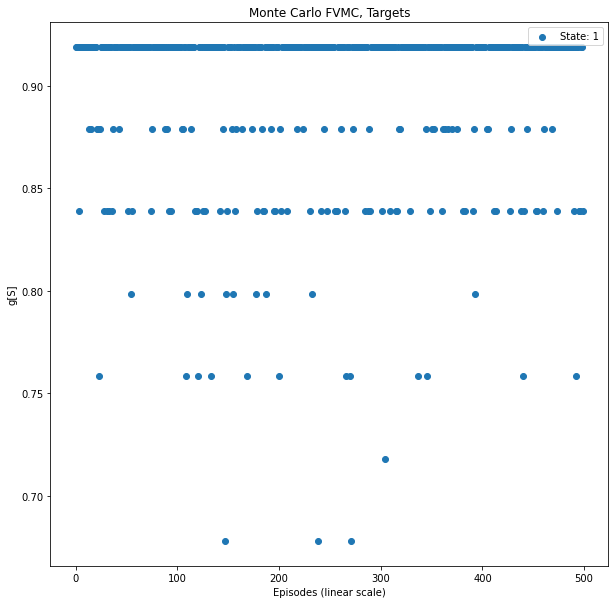

In [29]:
def targetFVMC(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing FVMC")
    vrs,g = monteCarloPrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=True, decayType='exponential')
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo FVMC, Targets")  
    plt.xlabel('Episodes (linear scale)')
    plt.ylabel('g[S]')
    plt.scatter(np.arange(500), g[:,1], label=('State: 1'))
    plt.legend()
    plt.show()

targetFVMC(pi)

Testing EVMC


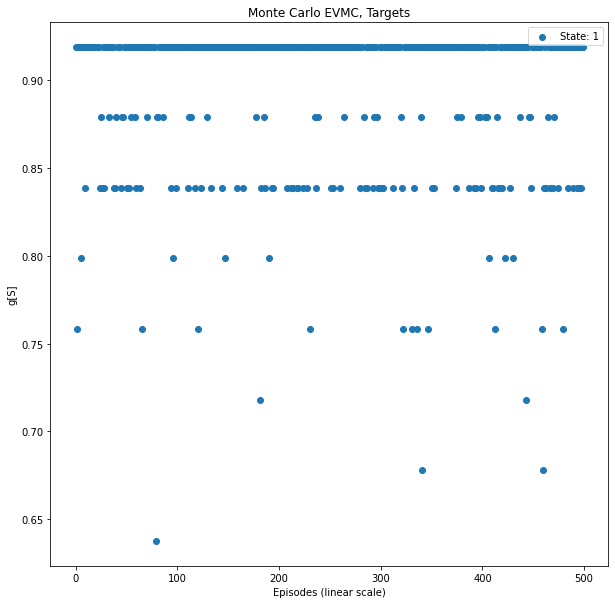

In [30]:
def targetEVMC(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing EVMC")
    vrs,g = monteCarloPrediction(env=rme, pi=pi, gamma=0.999, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=False, decayType='exponential')
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo EVMC, Targets")  
    plt.xlabel('Episodes (linear scale)')
    plt.ylabel('g[S]')
    plt.scatter(np.arange(500), g[:,1], label=('State: 1'))
    plt.legend()
    plt.show()

targetEVMC(pi)

Testing TD


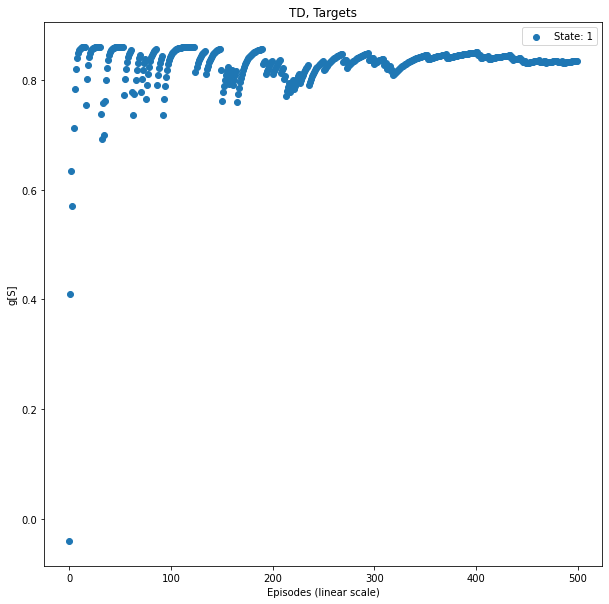

In [31]:
def targetTD(pi=None):
    if pi is None:
        pi = np.ones((12,))
    rme = gym.make('midsem.envs:RME-v0') 
    print("Testing TD")
    _,g = temporalDifferencePrediction(env=rme, pi=pi, gamma=0.9, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**2, decayType='exponential')
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("TD, Targets")  
    plt.xlabel('Episodes (linear scale)')
    plt.ylabel('g[S]')
    plt.scatter(np.arange(500), g[:,1], label=('State: 1'))
    plt.legend()
    plt.show()

targetTD(pi)